In [2]:
# Importing the necessary libraries
import torch  # Import PyTorch library
import torch.nn as nn  # Import neural network module
import torch.optim as optim  # Import optimization module
from torchvision import datasets, transforms  # Import datasets and transforms
from torchvision.utils import save_image, make_grid  # Import utility to save images
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision  # Import torchvision library
import matplotlib.pyplot as plt  # Import plotting library
import os  # Import os module for file operations
import numpy as np  # Import numpy library        nn.InstanceNorm2d(out_channels),
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.models import inception_v3
import numpy as np
from PIL import Image  # Import PIL for image processing
import scipy
from pathlib import Path
import math
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
import random

### Hyper-parameters

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 600
IMG_SIZE = 128
TRAIN_DDIM = True
BATCH_SIZE = 128
LR = 1e-4
STEP_GAMMA = 0.3
SCALING_FACTOR = 5000
NOISE_STEPS = 450
SAMPLING_STEPS = NOISE_STEPS

In [4]:
transform = transforms.Compose([
    # Randomly flip images horizontally
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    # Convert images to PyTorch tensors and scale to [0, 1]
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



animal_dataset = datasets.ImageFolder(root='/kaggle/input/animals/animals',  # Specify the root directory of the dataset
                               transform=transform)  # Apply the defined transformations to the dataset


dataloader = torch.utils.data.DataLoader(animal_dataset, 32, shuffle=True, num_workers=2)

In [5]:
image,_ = next(iter(dataloader))

In [6]:
import torch
import matplotlib.pyplot as plt

def divide_into_patches(image, patch_size):
    """
    Divides an image into non-overlapping patches.

    Args:
        image (torch.Tensor): Input image of shape (C, H, W).
        patch_size (int): Size of each square patch (patch_size x patch_size).

    Returns:
        torch.Tensor: A tensor of patches of shape (num_patches, C, patch_size, patch_size).
    """
    B,C, H, W = image.shape
    NUM_PATCHES = int(H*W/(patch_size**2))
 
    assert H % patch_size == 0 and W % patch_size == 0, \
        "Image dimensions must be divisible by patch size."

    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0,2, 3, 1, 4, 5).reshape(B, NUM_PATCHES,C, patch_size, patch_size)
    return patches


In [7]:
patches = divide_into_patches(image, 16)
patches.shape

torch.Size([32, 64, 3, 16, 16])

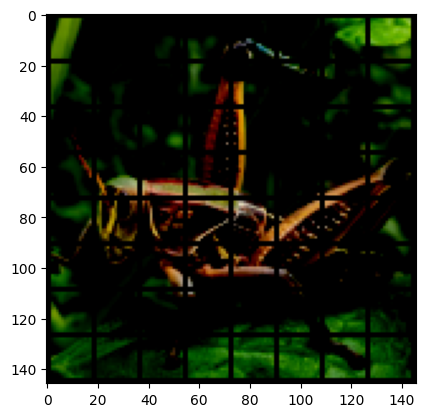

In [8]:
grid = torchvision.utils.make_grid(patches[10], nrow=8)
grid = grid.permute(1,2,0)
images = grid.detach().cpu().numpy()
plt.imshow(images)

In [9]:
def sample_context_blocks(patches, m=49, image_size=(128,128), patch_size=16 ):
    """
    Randomly selects m continuous patches forming a square block (LxL).
    
    Args:
        patches (torch.Tensor): Tensor of patches of shape (num_patches, C, patch_size, patch_size).
        image_size (tuple): Original image size as (H, W).
        patch_size (int): Size of each patch (patch_size x patch_size).
        m (int): Number of continuous patches to select.

    Returns:
        list: Indices of selected patches.
        torch.Tensor: Selected patches of shape (m, C, patch_size, patch_size).
    """
    H, W = image_size
    n_patches_h = H // patch_size
    n_patches_w = W // patch_size
    
    # Compute side length of the square block (LxL = m)
    side_length = int(m ** 0.5)
    assert side_length ** 2 == m, "m must be a perfect square to form a square block."

    # Randomly select a top-left corner for the square block
    max_row = n_patches_h - side_length
    max_col = n_patches_w - side_length
    start_row = random.randint(0, max_row)
    start_col = random.randint(0, max_col)

    # Collect indices of the patches in the square block
    context_indices = []
    for _ in range(patches.shape[0]):
        context_indices.append([
        (start_row + i) * n_patches_w + (start_col + j)
        for i in range(side_length)
        for j in range(side_length)
    ])

    masked_patches = patches.clone()
    for j in range(patches.shape[0]):
        for i in range(len(patches[j])):
            if i not in context_indices[j]:
                masked_patches[j][i] = torch.zeros_like(masked_patches[j][i])  # Mask unselected patches to zero
    
    return masked_patches, context_indices
   

In [10]:
context_blocks,context_indices = sample_context_blocks(patches=patches)
context_blocks.shape

torch.Size([32, 64, 3, 16, 16])

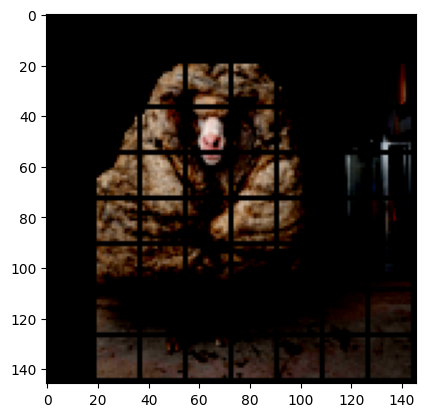

In [11]:
grid = torchvision.utils.make_grid(context_blocks[15], nrow=8)
grid = grid.permute(1,2,0)
images = grid.detach().cpu().numpy()
plt.imshow(images)

In [12]:
def sample_target_blocks(patches, m =9,  image_size=(128,128), patch_size=16):
    """
    Randomly selects m continuous patches forming a square block (LxL).
    
    Args:
        patches (torch.Tensor): Tensor of patches of shape (num_patches, C, patch_size, patch_size).
        image_size (tuple): Original image size as (H, W).
        patch_size (int): Size of each patch (patch_size x patch_size).
        m (int): Number of continuous patches to select.

    Returns:
        list: Indices of selected patches.
        torch.Tensor: Selected patches of shape (m, C, patch_size, patch_size).
    """
    H, W = image_size
    n_patches_h = H // patch_size
    n_patches_w = W // patch_size
    ar = (1.5 - 0.75) * torch.rand((1)) + 0.75 # aspect ratio
    
    # Compute side length of the target block
    side_length_h = int(ar*(m)**(0.5))
    side_length_w = int(m/side_length_h)
    
    # Randomly select a top-left corner for the square block
    max_row = n_patches_h - side_length_h
    max_col = n_patches_w - side_length_w
    start_row = random.randint(0, max_row)
    start_col = random.randint(0, max_col)

    # Collect indices of the patches in the square block
    target_indices = []
    for _ in range(patches.shape[0]):
        target_indices.append([
        (start_row + i) * n_patches_w + (start_col + j)
        for i in range(side_length_h)
        for j in range(side_length_w)
    ])

   

    masked_patches = patches.clone()
    for j in range(patches.shape[0]):
        for i in range(len(patches[j])):
            if i not in target_indices[j]:
                masked_patches[j][i] = torch.zeros_like(masked_patches[j][i])  # Mask unselected patches to zero
    
    return masked_patches, target_indices
    

In [13]:
target_blocks,target_indices = sample_target_blocks(patches)
target_blocks.shape

torch.Size([32, 64, 3, 16, 16])

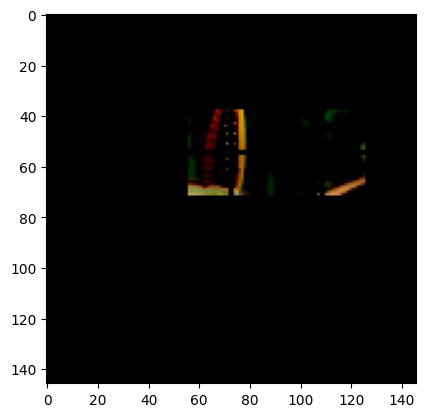

In [14]:
grid = torchvision.utils.make_grid(target_blocks[10], nrow=8)
grid = grid.permute(1,2,0)
images = grid.detach().cpu().numpy()
plt.imshow(images)

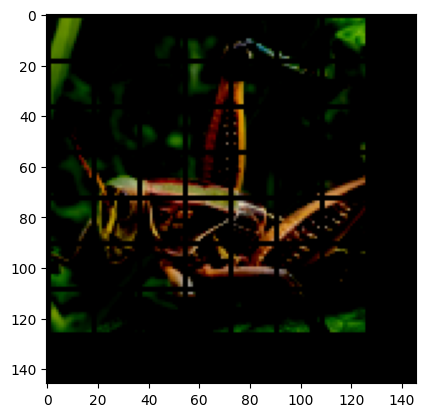

In [15]:
context_blocks, context_indices = sample_context_blocks(patches)
grid = torchvision.utils.make_grid(context_blocks[10], nrow=8)
grid = grid.permute(1,2,0)
images = grid.detach().cpu().numpy()
plt.imshow(images)

In [16]:
context_blocks, context_indices = sample_context_blocks(patches)
#context_indices = set(context_indices)
def remove_overlaps(context_blocks, context_indices, NUM_TARGETS=4):

    TARGET_INDICES = []
    for i in  range(NUM_TARGETS):
        target,indices = sample_target_blocks(patches)
        
        TARGET_INDICES.append(indices)
        
        if i == 0 :
            TARGET_BLOCKS = target.clone()
        else:
            TARGET_BLOCKS = torch.cat((TARGET_BLOCKS,target),dim=1)

        for i in range(len(indices)):   
            for idx in indices[i]:
                context_indices_i = set(context_indices[i])
                if idx  in context_indices_i:
                    context_blocks[i][idx] = torch.zeros_like(context_blocks[i][idx]) 
                    context_indices[i].remove(idx)
         
    return TARGET_BLOCKS.reshape(-1,4,64,3,16,16), TARGET_INDICES
    




In [17]:
t_b, _ = remove_overlaps(context_blocks, context_indices)

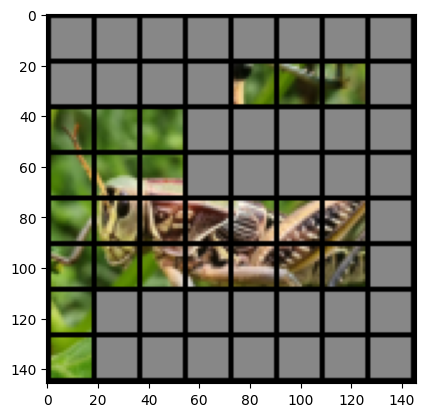

In [18]:
grid = torchvision.utils.make_grid(context_blocks[10], nrow=8, normalize=True)
grid = grid.permute(1,2,0)
images = grid.detach().cpu().numpy()
plt.imshow(images)

In [19]:
img = context_blocks[10].reshape(3,128,128)

In [202]:
class GetPatchEmbeddings(nn.Module):
    def __init__(self, patch_size=16):
        super(GetPatchEmbeddings, self).__init__()
        self.patch_size = patch_size

    def divide_into_patches(self,image , patch_size=16):
        """
        Divides an image into non-overlapping patches.

        Args:
            image (torch.Tensor): Input image of shape (C, H, W).
            patch_size (int): Size of each square patch (patch_size x patch_size).

        Returns:
            torch.Tensor: A tensor of patches of shape (num_patches, C, patch_size, patch_size).
        """
        image = image.to(device)
        B,C, H, W = image.shape
        NUM_PATCHES = int(H*W/(patch_size**2))
        patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size).to(device)
        patches = patches.permute(0,2, 3, 1, 4, 5).reshape(B, NUM_PATCHES,C, patch_size, patch_size).to(device)
        return patches
    
    def sample_context_blocks(self,patches, m=49, image_size=(128,128), patch_size=16 ):
        """
        Randomly selects m continuous patches forming a square block (LxL).
        
        Args:
            patches (torch.Tensor): Tensor of patches of shape (num_patches, C, patch_size, patch_size).
            image_size (tuple): Original image size as (H, W).
            patch_size (int): Size of each patch (patch_size x patch_size).
            m (int): Number of continuous patches to select.

        Returns:
            list: Indices of selected patches.
            torch.Tensor: Selected patches of shape (m, C, patch_size, patch_size).
        """
        H, W = image_size
        n_patches_h = H // patch_size
        n_patches_w = W // patch_size
        patches = patches.to(device)
        # Compute side length of the square block (LxL = m)
        side_length = int(m ** 0.5)
        assert side_length ** 2 == m, "m must be a perfect square to form a square block."

        # Randomly select a top-left corner for the square block
        max_row = n_patches_h - side_length
        max_col = n_patches_w - side_length
        start_row = random.randint(0, max_row)
        start_col = random.randint(0, max_col)

        # Collect indices of the patches in the square block
        context_indices = []
        for _ in range(patches.shape[0]):
            context_indices.append([
            (start_row + i) * n_patches_w + (start_col + j)
            for i in range(side_length)
            for j in range(side_length)
        ])

        masked_patches = patches.clone().to(device)
        for j in range(patches.shape[0]):
            for i in range(len(patches[j])):
                if i not in context_indices[j]:
                    masked_patches[j][i] = torch.zeros_like(masked_patches[j][i])  # Mask unselected patches to zero
        
        return masked_patches, context_indices
    
    def sample_target_blocks(self,patches, m =9,  image_size=(128,128), patch_size=16):
        """
        Randomly selects m continuous patches forming a square block (LxL).
        
        Args:
            patches (torch.Tensor): Tensor of patches of shape (num_patches, C, patch_size, patch_size).
            image_size (tuple): Original image size as (H, W).
            patch_size (int): Size of each patch (patch_size x patch_size).
            m (int): Number of continuous patches to select.

        Returns:
            list: Indices of selected patches.
            torch.Tensor: Selected patches of shape (m, C, patch_size, patch_size).
        """
        patches = patches.to(device)
        H, W = image_size
        n_patches_h = H // patch_size
        n_patches_w = W // patch_size
        ar = (1.5 - 0.75) * torch.rand((1)) + 0.75 # aspect ratio
        
        # Compute side length of the target block
        side_length_h = int(ar*(m)**(0.5))
        side_length_w = int(m/side_length_h)
        
        # Randomly select a top-left corner for the square block
        max_row = n_patches_h - side_length_h
        max_col = n_patches_w - side_length_w
        start_row = random.randint(0, max_row)
        start_col = random.randint(0, max_col)

        # Collect indices of the patches in the square block
        target_indices = []
        for _ in range(patches.shape[0]):
            target_indices.append([
            (start_row + i) * n_patches_w + (start_col + j)
            for i in range(side_length_h)
            for j in range(side_length_w)
        ])

        masked_patches = patches.clone().to(device)
        for j in range(patches.shape[0]):
            for i in range(len(patches[j])):
                if i not in target_indices[j]:
                    masked_patches[j][i] = torch.zeros_like(masked_patches[j][i])  # Mask unselected patches to zero
        
        return masked_patches, target_indices
    
    def remove_overlaps(self,context_blocks, context_indices, NUM_TARGETS=4):

        TARGET_INDICES = []
        for i in  range(NUM_TARGETS):
            target,indices = sample_target_blocks(patches)
            target = target.to(device)
            TARGET_INDICES.append(indices)
            
            if i == 0 :
                TARGET_BLOCKS = target.clone().to(device)
            else:
                TARGET_BLOCKS = torch.cat((TARGET_BLOCKS,target),dim=1).to(device)
            
            for j in range(context_blocks.shape[0]):   
                context_indices_j = context_indices[j]
                context_indices_j  = set(context_indices_j)
                for idx in indices[j]:
                    if idx  in context_indices_j:
                        context_blocks[j][idx] = torch.zeros_like(context_blocks[j][idx]) 
                        context_indices[j].remove(idx)
            context_blocks, TARGET_BLOCKS = context_blocks.to(device), TARGET_BLOCKS.to(device)
        return context_blocks, context_indices ,TARGET_BLOCKS.reshape(-1,4,64,3,16,16), TARGET_INDICES
    
    def forward(self, x):

        patches = self.divide_into_patches(x)
        context, context_indices = self.sample_context_blocks(patches)
        
        
        context, context_indices,targets, target_indices  = self.remove_overlaps(context, context_indices)
        return context, context_indices, targets, target_indices
    
    
   
    

In [203]:
patchembedder  = GetPatchEmbeddings().to(device)
c,_,t,ti  = patchembedder(image)
ti

[[[0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10, 16, 17, 18],
  [0, 1, 2, 8, 9, 10

In [204]:
class GetPositionalEmbeddings(nn.Module):
    def __init__(self):
        super(GetPositionalEmbeddings, self).__init__()

    def get_1d_sincos_pos_embed_from_grid(self,embed_dim, pos):
        """
        embed_dim: output dimension for each position
        pos: a list of positions to be encoded: size (M,)
        out: (M, D)
        """
        assert embed_dim % 2 == 0
        omega = np.arange(embed_dim // 2, dtype=float)
        omega /= embed_dim / 2.
        omega = 1. / 10000**omega   # (D/2,)

        pos = pos.reshape(-1)   # (M,)
        out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product

        emb_sin = np.sin(out)  # (M, D/2)
        emb_cos = np.cos(out)  # (M, D/2)

        emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
        return emb
    
    def get_1d_sincos_pos_embed(self,embed_dim, grid_size, cls_token=False):
        """
        grid_size: int of the grid length
        return:
        pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
        """
        grid = np.arange(grid_size, dtype=float)
        pos_embed = self.get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
        if cls_token:
            pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
        return pos_embed
    

    def get_2d_sincos_pos_embed_from_grid(self,embed_dim, grid):
        assert embed_dim % 2 == 0

        # use half of dimensions to encode grid_h
        emb_h = self.get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
        emb_w = self.get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

        emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
        return emb
    
    def get_2d_sincos_pos_embed(self,embed_dim, grid_size, cls_token=False):
        """
        grid_size: int of the grid height and width
        return:
        pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
        """
        grid_h = np.arange(grid_size, dtype=float)
        grid_w = np.arange(grid_size, dtype=float)
        grid = np.meshgrid(grid_w, grid_h)  # here w goes first
        grid = np.stack(grid, axis=0)

        grid = grid.reshape([2, 1, grid_size, grid_size])
        pos_embed = self.get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
        if cls_token:
            pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
        return pos_embed
    
    def forward(self, grid_size):
        pos_emb = self.get_2d_sincos_pos_embed(768, grid_size)
        return pos_emb

In [205]:
get_positional_embeddings = GetPositionalEmbeddings().to(device)
x = get_positional_embeddings.get_1d_sincos_pos_embed_from_grid(768, pos = np.array([1,2,3,4]))
x.shape

(4, 768)

In [217]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.head_dim = embed_dim // num_heads
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: Optional[torch.Tensor] = None):
        batch_size = query.shape[0]
        
        # Linear projections
        Q = self.query(query)  # (batch_size, seq_len, embed_dim)
        K = self.key(key)      # (batch_size, seq_len, embed_dim)
        V = self.value(value)  # (batch_size, seq_len, embed_dim)

        # Split into multiple heads
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)

        # Scaled dot-product attention
        energy = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy, dim=-1).to(device)  # (batch_size, num_heads, seq_len, seq_len)
        out = torch.matmul(attention, V).to(device)  # (batch_size, num_heads, seq_len, head_dim)

        # Concatenate heads and pass through final linear layer
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        out = self.fc_out(out)  # (batch_size, seq_len, embed_dim)

        return out


class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_hid_dim: int, dropout: float):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_hid_dim),
            nn.ReLU(),
            nn.Linear(ff_hid_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        # Attention
        attention_out = self.attention(x, x, x, mask).to(device)
        x = self.norm1(attention_out + x)  # Residual connection
        
        # Feed-forward network
        ffn_out = self.ffn(x)
        x = self.norm2(ffn_out + x)  # Residual connection
        
        return self.dropout(x)


class VisionTransformer(nn.Module):
    def __init__(self,patchembedder,positionembedder, image_size: int, patch_size: int, in_channels: int, embed_dim: int, num_heads: int, 
                 num_layers: int, ff_hid_dim: int, dropout: float, max_len: int = 512, target:bool = False):
        super(VisionTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = patchembedder
        self.position_embedding = positionembedder
        self.target = target
        # Patch embedding
        #self.patch_embedding = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # Positional encoding
        #self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        
        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_hid_dim, dropout)
            for _ in range(num_layers)
        ]).to(device)

        
    def forward(self, x: torch.Tensor, target_rep: Optional[torch.Tensor] = None, target_indices :Optional [list] = None):
        # Step 1: Patch embedding
        if self.target == False:
            batch_size = x.size(0)
            x,_,target,target_indices = self.patch_embedding(x) # (B, embed_dim, H/patch_size, W/patch_size)
                
            x = x.flatten(2) # (B, num_patches, embed_dim)
                
            # Step 2: Add positional embedding
            pos_emb = torch.from_numpy(self.position_embedding(8)).unsqueeze(dim=0).repeat_interleave(repeats = batch_size, dim=0).to(device)
            pos_emb = pos_emb.float()
            x =x+  pos_emb
                
            # Step 3: Pass through transformer layers
            for layer in self.encoder_layers:
                x = layer(x)
                
            # Step 4: Return output for each patch
            x, target  =x.to(device), target.to(device)
            return x , target, target_indices # (B, num_patches, embed_dim)
        else:
            batch_size = x.size(0)
            target_representations = []
            #_,_,target_blocks,target_indices = self.patch_embedding(x)  # (B, embed_dim, H/patch_size, W/patch_size)
            target_blocks = target_rep.to(device)
            for i in range(target_blocks.shape[1]):
                x = target_blocks[:,i,:,:].flatten(2) # (B, num_patches, embed_dim)
                
                # Step 2: Add positional embedding
                pos_emb = torch.from_numpy(self.position_embedding(8)).unsqueeze(dim=0).repeat_interleave(repeats = batch_size, dim=0).to(device)
                pos_emb = pos_emb.float()
                x = x+  pos_emb
                
                # Step 3: Pass through transformer layers
                for layer in self.encoder_layers:
                    x = layer(x)
                
                target_representations.append(x)
            #target_representations = torch.tensor(target_representations)
            # Step 4: Return output for each patch
            return target_representations  # (B, num_patches, embed_dim)
        



# Example usage
if __name__ == "__main__":
    # Initialize Vision Transformer
    vit = VisionTransformer(
        patchembedder,
        get_positional_embeddings,
        image_size=128,
        patch_size=16,
        in_channels=3,
        embed_dim=768,
        num_heads=8,
        num_layers=6,
        ff_hid_dim=2048,
        dropout=0.1,
        target=False
    )

    # Example input image (batch size of 1, RGB 128x128 image)
    input_image = torch.randn(32, 3, 128, 128)

    # Forward pass
    output = vit(input_image)
    #print(f"Output shape: {output.shape}")  # Expected: (1, num_patches, embed_dim), e.g. (1, 64, 768)
    #print(f"Output shape: {output.shape}") 

In [218]:
context_enocder = VisionTransformer(
        patchembedder,
        get_positional_embeddings,
        image_size=128,
        patch_size=16,
        in_channels=3,
        embed_dim=768,
        num_heads=8,
        num_layers=6,
        ff_hid_dim=768,
        dropout=0.1,
        target=False
    )

In [219]:
target_encoder = VisionTransformer(
        patchembedder,
        get_positional_embeddings,
        image_size=128,
        patch_size=16,
        in_channels=3,
        embed_dim=768,
        num_heads=8,
        num_layers=6,
        ff_hid_dim=768,
        dropout=0.1,
        target=True
    )

In [220]:
x= context_enocder(image)
c, t, ti = x
c.shape

torch.Size([32, 64, 768])

In [221]:
x = target_encoder(image, t, ti)
x[0].device

device(type='cuda', index=0)

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.head_dim = embed_dim // num_heads
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: Optional[torch.Tensor] = None):
        batch_size = query.shape[0]
        
        # Linear projections
        Q = self.query(query)  # (batch_size, seq_len, embed_dim)
        K = self.key(key)      # (batch_size, seq_len, embed_dim)
        V = self.value(value)  # (batch_size, seq_len, embed_dim)

        # Split into multiple heads
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)

        # Scaled dot-product attention
        energy = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        out = torch.matmul(attention, V)  # (batch_size, num_heads, seq_len, head_dim)

        # Concatenate heads and pass through final linear layer
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        out = self.fc_out(out)  # (batch_size, seq_len, embed_dim)

        return out


class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_hid_dim: int, dropout: float):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_hid_dim),
            nn.ReLU(),
            nn.Linear(ff_hid_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        # Attention
        attention_out = self.attention(x, x, x, mask)
        x = attention_out + x
        x = self.norm1(attention_out + x) 
        # Residual connection
        # Feed-forward network
        ffn_out = self.ffn(x)
        x = self.norm2(ffn_out + attention_out)  # Residual connection
        return self.dropout(x)


class VisionTransformer_predictor(nn.Module):
    def __init__(self,positionembedder, image_size: int, patch_size: int, in_channels: int, embed_dim: int, num_heads: int, 
                 num_layers: int, ff_hid_dim: int, dropout: float, max_len: int = 512, target:bool = False):
        super(VisionTransformer_predictor, self).__init__()
        
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.position_embedding = positionembedder.to(device)
        
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_hid_dim, dropout)
            for _ in range(num_layers)
        ]).to(device)
        self.main = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 768)
        )
    def get_mask_embeddings(self,x,target_list : list):
        batch_size =x.shape[0]
        pos_emb = torch.from_numpy(self.position_embedding(8)).unsqueeze(dim=0).repeat_interleave(repeats =batch_size , dim=0).to(device)
        pos_emb = pos_emb.float()
        for i in range(len(target_list)):
            pos_masks = self.position_embedding.get_1d_sincos_pos_embed_from_grid(768, pos = np.array(target_list[i]))
            pos_masks = torch.from_numpy(pos_masks).to(device)
            pos_masks = torch.cat([pos_masks, torch.zeros(pos_emb[i].shape[0] - pos_masks.shape[0], 768).to(device)], dim=0).to(device)
            pos_emb[i] =  pos_emb[i] + pos_masks

        return pos_emb
        
    def forward(self, x: torch.Tensor, target_lists: list):
        # Step 1: Patch embedding
        #batch_size = x.size(0)
        #x,_,_,_ = self.patch_embedding(x)  # (B, embed_dim, H/patch_size, W/patch_size)
                
        #x = x.flatten(2) # (B, num_patches, embed_dim)
                
        # Step 2: Add positional embedding
        #pos_emb = torch.from_numpy(self.position_embedding(8)).unsqueeze(dim=0).repeat_interleave(repeats = 32, dim=0)
        x = x.to(device)
        pos_emb = self.get_mask_embeddings(x,target_lists)  
        pos_emb = pos_emb.float()
        x = x + pos_emb
                
        # Step 3: Pass through transformer layers
        for layer in self.encoder_layers:
            x = layer(x)
                
        # Step 4: Return output for each patch
        return x  # (B, num_patches, embed_dim)
        





In [223]:
x = torch.randn(32,64,768).to(device)
loss  = torch.mean(torch.square(output-c))
loss.backward( retain_graph=True)

TypeError: unsupported operand type(s) for -: 'tuple' and 'Tensor'

In [224]:
predictor = VisionTransformer_predictor(
        get_positional_embeddings,
        image_size=128,
        patch_size=16,
        in_channels=3,
        embed_dim=768,
        num_heads=4,
        num_layers=6,
        ff_hid_dim=384,
        dropout=0.1,
        
    )

In [225]:
def loss_fn(context, target_representaions, target_indices, predictor_model):
    loss = 0
    for i in range(len(target_representaions)):
        context_representations = predictor_model(context.detach(), target_indices[i])
        loss  += torch.mean(torch.sqrt(torch.sum(torch.square(context_representations-target_representaions[i]))))

    return loss/len(target_representaions)

In [228]:
def train_iJEPA(context_model, target_model, predictor_model, num_epochs = 10):
    context_model  = context_model.to(device)
    target_model = target_model.to(device)
    predictor_model = predictor_model.to(device)
    dataloader = torch.utils.data.DataLoader(animal_dataset, batch_size =32 , shuffle = True, num_workers=True, drop_last=True)
    context_opt = torch.optim.Adam(context_model.parameters(), lr = 1e-4)
    predictor_opt = torch.optim.Adam(predictor_model.parameters(), lr  =1e-4)
    
    for param in target_model.parameters():
        param.requires_grad = False
    train_losses = []
    context_model.train()
    predictor_model.train()
    for epochs in range(num_epochs):
        avg_loss = 0
        for x,_ in tqdm(dataloader):
            with torch.autograd.set_detect_anomaly(True):
                x = x.to(device)
                context_opt.zero_grad()
                predictor_opt.zero_grad()
                context, target, target_indices = context_model(x)
                with torch.no_grad():
                    target_representations = target_model(x,target, target_indices)
                loss = loss_fn(context.detach(), target_representations, target_indices, predictor_model)
                avg_loss += loss.item()
                #print(loss)
                loss.backward(retain_graph = True, create_graph  =True)
                context_opt.step()
                predictor_opt.step()
                with torch.no_grad():
                    for param_q, param_k in zip(context_model.parameters(), target_model.parameters()):
                        param_k.data.mul_(0.996).add_((1.-0.996) * param_q.detach().data)
        avg_loss/=len(dataloader)
        train_losses.append(avg_loss)
        print(f"epoch:{epochs} | avg_loss: {avg_loss}")

    
    print('finished Training')

In [229]:
train_iJEPA(context_enocder, target_encoder, predictor, num_epochs=10)

100%|██████████| 168/168 [03:16<00:00,  1.17s/it]


epoch:0 | avg_loss: 1134.6232532319568


100%|██████████| 168/168 [03:18<00:00,  1.18s/it]


epoch:1 | avg_loss: 1093.1957462855748


100%|██████████| 168/168 [03:17<00:00,  1.17s/it]


epoch:2 | avg_loss: 1056.4608691987537


100%|██████████| 168/168 [03:19<00:00,  1.19s/it]


epoch:3 | avg_loss: 1030.8102079119


100%|██████████| 168/168 [03:17<00:00,  1.17s/it]


epoch:4 | avg_loss: 1013.8455458141509


100%|██████████| 168/168 [03:18<00:00,  1.18s/it]


epoch:5 | avg_loss: 1002.476082211449


100%|██████████| 168/168 [03:14<00:00,  1.16s/it]


epoch:6 | avg_loss: 994.4976654052734


100%|██████████| 168/168 [03:14<00:00,  1.16s/it]


epoch:7 | avg_loss: 989.1436284383138


100%|██████████| 168/168 [03:15<00:00,  1.16s/it]


epoch:8 | avg_loss: 985.2283604939779


100%|██████████| 168/168 [03:15<00:00,  1.16s/it]

epoch:9 | avg_loss: 982.574572971889
finished Training
